In [2]:
# gets all of numpy but you will still need to refer to e.g. numpy.random.randn() as random.randn()
from numpy import *               # all of the array capable elements for numerical data          
from scipy.stats import norm      # comprehensive functions for Gaussian normal distributions
import csv                        # library for reading and writing comma separated value files
from matplotlib.pyplot import *   # all of pyplot to graph the results of our calculations

# put figures inline in the notebook, so you don't have to call show()
%matplotlib inline

# This lets you make the default figure size larger (or smaller)
from IPython.core.pylabtools import figsize
#figsize(14, 7)

# PID Control of Thermal Systems

Not required for MECH 217, but interesting. The combination of multiple first order temperature responses yields a higher order system response. The equation system becomes non-linear when we introduce real world factors, like a heater with a fixed range of outputs between 0 and some maximum value. Such non-linear changes are not easy to model analytically.

<a href="http://www.youtube.com/watch?feature=player_embedded&v=THUka7Q8kj0
" target="_blank"><img src="http://img.youtube.com/vi/THUka7Q8kj0/0.jpg" 
alt="IMAGE ALT TEXT HERE" width="240" height="180" border="10" /></a>

In this video we developed the idea that the response of a temperature sensor to it's surroundings would follow a first order model

\begin{equation} 
\frac{dT_s}{dt} = \frac{1}{\tau}(T_a-T_s)\quad{\rm where}\quad \tau = \frac{mC_p}{hA_s}
\end{equation}

and $t$ is time, $T_a$ the temperature of the surroundings and $T_s$ the temperature of the sensor. We can approximate this following Euler's method as

\begin{equation} 
T_{s_{\rm new}} = T_{s_{\rm old}} + 
\frac{1}{\tau}
(T_{a_{\rm old}}-T_{s_{\rm old}})\Delta t
\end{equation}

to estimate the new value for the sensor temperature a short time later based on the conditions at the previous time step.

For a step change in temperature at time $t_0$, we have an analytical solution from ODEs of 

\begin{equation}
T_s = T_1 - e^{-(t-t_0)/\tau}(T_1-T_0) \quad\quad{\rm for}\quad\quad t\ge t_0
\end{equation}

## Time Response for a Heated Block (or Bath)

\begin{equation} 
\frac{dT_b}{dt} = \frac{hA}{mC_p}(T_a-T_b) + \frac{Q}{mC_p}
\end{equation}

Governs the changing temperature for a block of material with heat input Q in much the same way as the balance on the sensor above. The block will get warmer by the heating and by convection if the ambient surroundings are warmer. The equation can be simplified if we have measured the time constant with heater switched off  

\begin{equation} 
\frac{dT_b}{dt} = \frac{1}{\tau_b}(T_a-T_b) + \frac{Q}{mC_p}
\end{equation}

and Euler's method can be applied if we keep the time step short. If I attach the two sensors to the block so that they follow the block temperature, then I could turn the heater up and down to control the temperature, based on whatever algorithm I chose for that control. The time constants for the sensors will depend on how well they are attached to the block and define how closely they follow the block temperature. The code below uses a simple set/reset thermostat control `QSR()` to turn the heater on and off.

## Solve Differential Equation for the System
This segment has the necessary code to calculate new values for TB[i], the temperature of the block, and two sensor temperatures, TTMP[ ] and TTC[ ]  interacting with the block at TB. Constant values representing the characteristics of the block are in the preamble code. Why does T overshoot more on the high side than on the low side of the set/reset range?

(-100, 2100)

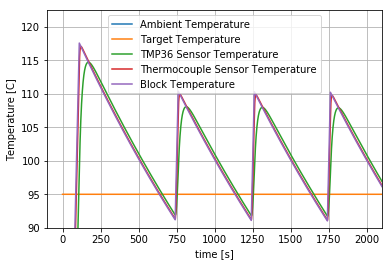

In [12]:
TauB = 2000         # the time constant for the block [s]
mCpB = 2000         # the heat capacity for the block
TauTC = 4           # the time constant for the thermocouple is fast [s]
TauTMP = 20         # the time constant for the TMP36 is slower [s]
t0 = 5              # the time of the step change in set point [s]
tr = 12000          # time range of interest [s]
dtC = 10            # the control time step [s] -- controller only changes this often
nC = 10             # number of simulation steps in a control step [s] -- simulate faster
dt = dtC/nC         # the simulation time step [s]
n=int(tr/dt)        # enough points to be nearly continuous

def Tact(t):                # The actual ambient temperature as a function of time
    return 20               # constant ambient temperature

Heat = 1                    # Heat on or off
Qmax = 2000                 # Max Heat in Watts
Tset = 92                   # Turn heater on below this temperature [C]
Treset = 98                 # Turn Heater off above this temperature [C]
Ttarget = (Tset+Treset)/2   # Try to hit this temperature exactly [C]

def QSR(t,T,err,d,i):       # Return the amount of heat generated by the heater as a function of 
    global Heat             # time and sensor temperature
    if(T > Treset): Heat = 0# turn off if too hot
    if(T < Tset):  Heat = 1 # turn on if too cold, don't switch too often
    return Qmax * Heat      # heater either on or off


def blockCalc(Q,noPlot = 0):
    # Plot the step function and the ODE solution for a continuous system
    t = np.linspace(0,tr,n)
    T = t.copy()
    for i in range (0,n): T[i] = Tact(t[i])
    TTMP = T.copy()
    TTC = T.copy()
    TB = T.copy()
    Tobj = Ttarget * ones(len(t))
    Terr = zeros(len(T))        # the error at each step
    QA = zeros(len(T))        # the heat input at each step
    iTerr = 0        # integral of the error starts out as zero

    for i in range (1,n):  # advance 3 ODEs simultanteously 
        TB[i] = TB[i-1] + (1/TauB * (T[i-1]-TB[i-1]) + QA[i-1]/mCpB) * dt 
        TTC[i] = TTC[i-1] + 1/TauTC * (TB[i-1]-TTC[i-1]) * dt
        TTMP[i] = TTMP[i-1] + 1/TauTMP * (TB[i-1]-TTMP[i-1]) * dt
        Ts = TTMP[i]       # pick which sensor to control with
        Terr[i] = Tobj[i]-Ts            # difference between what you have and what you want
        dTerr = (Terr[i]-Terr[i-1])/dt  # how fast that difference is changing
        iTerr += Terr[i]*dt             # how long that difference is been off balance in one direction
        # update the heating rate on the time scale of the controller
        if(i%nC == 0): QA[i] = Q(t[i],Ts,Terr[i],dTerr,iTerr)
        else: QA[i] = QA[i-1]
        QA[i] = max(0,min(QA[i],Qmax))  # stay within the limits of the heating hardware
    
    if(noPlot == 0):
        plot(t,T,label = 'Ambient Temperature')
        plot(t,Tobj,label = 'Target Temperature')
        plot(t,TTMP,label = 'TMP36 Sensor Temperature')
        plot(t,TTC,label = 'Thermocouple Sensor Temperature')
        plot(t,TB,label = 'Block Temperature')
        xlabel('time [s]')
        ylabel('Temperature [C]')
        legend()
        grid()
    return (t,TB)
    
t,TB1 = blockCalc(QSR)
ylim(90)
xlim(-100,2100)


The temperature overshoots the desired range, with short periods of full on heating whenever the sensor temperature is below the desired range. `QSR()` ignores the information about how far we are from the desired range (`err`), how fast we are getting closer (`d`), and how long we have been wrong in the same direction (`i`).

Maybe things would be better if we reduced the total amount of heat as we get closer. `QP()` makes the heat input proportional to how far we are below the desired temperature. Try different values of the proportional control gain `Gp`.

(90, 113.10574348579615)

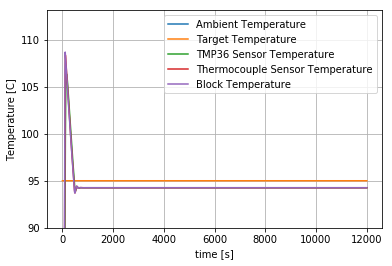

In [13]:
def QP(t,T,err,d,i,Gp = 100 ):        # Proportional Control
    return max(0,Gp * err)   

blockCalc(QP)
ylim(90)


Proportional control will always settle into equilibrium with an error between the desired temperature and the results. Adding an integral term allows you to push the temperature up if it has been consistently low for a long time. Try different integral gains `Gi`.

(90, 118.41870456535835)

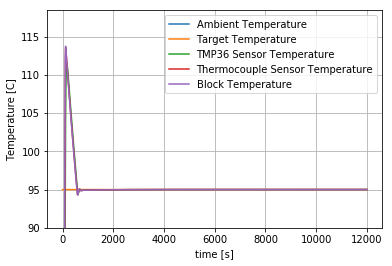

In [14]:
def QPI(t,T,err,d,i,Gp = 100,Gi = .1 ):        # Proportional + Integral Control
    Q = Gp * err + Gi * i
    return max(0,Q)   

blockCalc(QPI)
ylim(90)


Finally, you can reduce the overshoot by making the controller sensitive to how fast you are approaching the desired results. The time derivative of the difference provides that input through the differential gain `Gd`. Try different values to see the effects. 

(90, 100.922193568711)

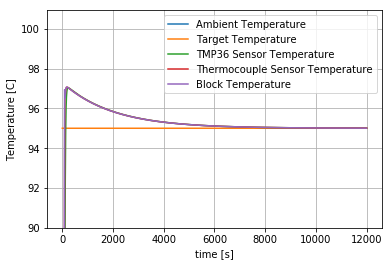

In [15]:
def QPID(t,T,err,d,i,Gp = 200,Gi = .1,Gd = 4000):        # Proportional + Integral + Differential Control
    Q = Gp * err + Gi * i + Gd * d   
    return max(0,Q)   

blockCalc(QPID)
ylim(90)
